In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:30 - loss: 0.1404 - STD: 1.6249e-04 - MAE: 0.3619

 4/74 [>.............................] - ETA: 1s - loss: 0.0512 - STD: 3.8911e-04 - MAE: 0.1728  

 7/74 [=>............................] - ETA: 1s - loss: 0.0450 - STD: 2.6606e-04 - MAE: 0.1665

10/74 [===>..........................] - ETA: 1s - loss: 0.0422 - STD: 1.9888e-04 - MAE: 0.1624

13/74 [====>.........................] - ETA: 1s - loss: 0.0376 - STD: 1.7306e-04 - MAE: 0.1488

16/74 [=====>........................] - ETA: 1s - loss: 0.0330 - STD: 1.6436e-04 - MAE: 0.1338

19/74 [======>.......................] - ETA: 1s - loss: 0.0304 - STD: 1.5818e-04 - MAE: 0.1304

22/74 [=======>......................] - ETA: 1s - loss: 0.0285 - STD: 1.5085e-04 - MAE: 0.1281

25/74 [=========>....................] - ETA: 0s - loss: 0.0265 - STD: 1.4272e-04 - MAE: 0.1220

27/74 [=========>....................] - ETA: 1s - loss: 0.0258 - STD: 1.3744e-04 - MAE: 0.1175

30/74 [===========>..................] - ETA: 1s - loss: 0.0246 - STD: 1.3055e-04 - MAE: 0.1120

33/74 [============>.................] - ETA: 1s - loss: 0.0236 - STD: 1.2536e-04 - MAE: 0.1073

36/74 [=============>................] - ETA: 1s - loss: 0.0226 - STD: 1.2206e-04 - MAE: 0.1037

39/74 [==============>...............] - ETA: 1s - loss: 0.0218 - STD: 1.2044e-04 - MAE: 0.1018

42/74 [================>.............] - ETA: 1s - loss: 0.0212 - STD: 1.1983e-04 - MAE: 0.1005

45/74 [=================>............] - ETA: 0s - loss: 0.0206 - STD: 1.1973e-04 - MAE: 0.0990

48/74 [==================>...........] - ETA: 0s - loss: 0.0200 - STD: 1.1987e-04 - MAE: 0.0971

51/74 [===================>..........] - ETA: 0s - loss: 0.0196 - STD: 1.2040e-04 - MAE: 0.0951

54/74 [====================>.........] - ETA: 0s - loss: 0.0192 - STD: 1.2162e-04 - MAE: 0.0933

57/74 [======================>.......] - ETA: 0s - loss: 0.0188 - STD: 1.2366e-04 - MAE: 0.0920

60/74 [=======================>......] - ETA: 0s - loss: 0.0184 - STD: 1.2646e-04 - MAE: 0.0911

63/74 [========================>.....] - ETA: 0s - loss: 0.0181 - STD: 1.2987e-04 - MAE: 0.0903

66/74 [=========================>....] - ETA: 0s - loss: 0.0179 - STD: 1.3369e-04 - MAE: 0.0894

69/74 [==========================>...] - ETA: 0s - loss: 0.0176 - STD: 1.3801e-04 - MAE: 0.0884

72/74 [============================>.] - ETA: 0s - loss: 0.0174 - STD: 1.4284e-04 - MAE: 0.0875

74/74 [==============================] - 4s 37ms/step - loss: 0.0172 - STD: 1.4646e-04 - MAE: 0.0870 - val_loss: 0.0145 - val_STD: 2.0604e-04 - val_MAE: 0.0726


Epoch 2/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0119 - STD: 2.9415e-04 - MAE: 0.0679

 4/74 [>.............................] - ETA: 1s - loss: 0.0122 - STD: 3.1159e-04 - MAE: 0.0697

 7/74 [=>............................] - ETA: 1s - loss: 0.0121 - STD: 3.2993e-04 - MAE: 0.0701

10/74 [===>..........................] - ETA: 1s - loss: 0.0120 - STD: 3.4859e-04 - MAE: 0.0700

13/74 [====>.........................] - ETA: 1s - loss: 0.0120 - STD: 3.6895e-04 - MAE: 0.0696

16/74 [=====>........................] - ETA: 1s - loss: 0.0120 - STD: 3.9127e-04 - MAE: 0.0693

20/74 [=======>......................] - ETA: 1s - loss: 0.0120 - STD: 4.2602e-04 - MAE: 0.0692

23/74 [========>.....................] - ETA: 0s - loss: 0.0120 - STD: 4.5636e-04 - MAE: 0.0694

26/74 [=========>....................] - ETA: 0s - loss: 0.0120 - STD: 4.9046e-04 - MAE: 0.0695

29/74 [==========>...................] - ETA: 0s - loss: 0.0120 - STD: 5.2820e-04 - MAE: 0.0695

32/74 [===========>..................] - ETA: 0s - loss: 0.0120 - STD: 5.7088e-04 - MAE: 0.0694

35/74 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 6.2006e-04 - MAE: 0.0693

38/74 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 6.7661e-04 - MAE: 0.0693

41/74 [===============>..............] - ETA: 0s - loss: 0.0120 - STD: 7.4219e-04 - MAE: 0.0693

44/74 [================>.............] - ETA: 0s - loss: 0.0119 - STD: 8.1752e-04 - MAE: 0.0692

47/74 [==================>...........] - ETA: 0s - loss: 0.0119 - STD: 9.0611e-04 - MAE: 0.0691

50/74 [===================>..........] - ETA: 0s - loss: 0.0119 - STD: 0.0010 - MAE: 0.0690    

53/74 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 0.0011 - MAE: 0.0689

56/74 [=====================>........] - ETA: 0s - loss: 0.0119 - STD: 0.0013 - MAE: 0.0688

59/74 [======================>.......] - ETA: 0s - loss: 0.0118 - STD: 0.0015 - MAE: 0.0687

62/74 [========================>.....] - ETA: 0s - loss: 0.0118 - STD: 0.0017 - MAE: 0.0685

65/74 [=========================>....] - ETA: 0s - loss: 0.0117 - STD: 0.0020 - MAE: 0.0684

68/74 [==========================>...] - ETA: 0s - loss: 0.0117 - STD: 0.0023 - MAE: 0.0683

71/74 [===========================>..] - ETA: 0s - loss: 0.0116 - STD: 0.0027 - MAE: 0.0681

74/74 [==============================] - ETA: 0s - loss: 0.0116 - STD: 0.0033 - MAE: 0.0678

74/74 [==============================] - 2s 23ms/step - loss: 0.0116 - STD: 0.0033 - MAE: 0.0678 - val_loss: 0.0116 - val_STD: 0.0122 - val_MAE: 0.0631


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0096 - STD: 0.0180 - MAE: 0.0599

 4/74 [>.............................] - ETA: 1s - loss: 0.0095 - STD: 0.0208 - MAE: 0.0605

 7/74 [=>............................] - ETA: 1s - loss: 0.0090 - STD: 0.0232 - MAE: 0.0591

11/74 [===>..........................] - ETA: 1s - loss: 0.0087 - STD: 0.0270 - MAE: 0.0575

14/74 [====>.........................] - ETA: 1s - loss: 0.0083 - STD: 0.0304 - MAE: 0.0562

17/74 [=====>........................] - ETA: 1s - loss: 0.0079 - STD: 0.0337 - MAE: 0.0547

20/74 [=======>......................] - ETA: 1s - loss: 0.0075 - STD: 0.0373 - MAE: 0.0534

23/74 [========>.....................] - ETA: 0s - loss: 0.0072 - STD: 0.0407 - MAE: 0.0522

26/74 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0442 - MAE: 0.0510

29/74 [==========>...................] - ETA: 0s - loss: 0.0065 - STD: 0.0476 - MAE: 0.0499

32/74 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0508 - MAE: 0.0489

35/74 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0538 - MAE: 0.0479

38/74 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0565 - MAE: 0.0471

41/74 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0464

44/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0457

47/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0451

50/74 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0646 - MAE: 0.0445

53/74 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0662 - MAE: 0.0440

56/74 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0435

59/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0431

62/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0427

65/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0423

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0419

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0416

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0413

74/74 [==============================] - 2s 23ms/step - loss: 0.0044 - STD: 0.0743 - MAE: 0.0413 - val_loss: 0.0026 - val_STD: 0.0679 - val_MAE: 0.0321


Epoch 4/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0337

 4/74 [>.............................] - ETA: 1s - loss: 0.0026 - STD: 0.0945 - MAE: 0.0334

 7/74 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.0949 - MAE: 0.0334

10/74 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.0950 - MAE: 0.0332

13/74 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.0957 - MAE: 0.0331

16/74 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0957 - MAE: 0.0330

19/74 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0956 - MAE: 0.0328

22/74 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.0956 - MAE: 0.0327

25/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0958 - MAE: 0.0326

28/74 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0326

30/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0959 - MAE: 0.0325

33/74 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0324

36/74 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.0959 - MAE: 0.0323

39/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0322

42/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0321

45/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0320

48/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0319

51/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0962 - MAE: 0.0318

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0962 - MAE: 0.0317

57/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0962 - MAE: 0.0316

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0963 - MAE: 0.0316

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0963 - MAE: 0.0315

65/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0964 - MAE: 0.0315

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0964 - MAE: 0.0314

71/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0965 - MAE: 0.0313

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0965 - MAE: 0.0313

74/74 [==============================] - 2s 24ms/step - loss: 0.0023 - STD: 0.0965 - MAE: 0.0313 - val_loss: 0.0024 - val_STD: 0.0716 - val_MAE: 0.0288


Epoch 5/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0297

 4/74 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.0980 - MAE: 0.0295

 7/74 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.0974 - MAE: 0.0297

10/74 [===>..........................] - ETA: 1s - loss: 0.0021 - STD: 0.0979 - MAE: 0.0299

13/74 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0979 - MAE: 0.0299

16/74 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0978 - MAE: 0.0299

19/74 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0298

22/74 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0298

25/74 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0298

28/74 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0297

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0296

34/74 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0295

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0295

40/74 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0295

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0294

46/74 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0294

49/74 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0293

52/74 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0293

55/74 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0292

58/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0292

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0292

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0292

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0291

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0291

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0291

74/74 [==============================] - 2s 25ms/step - loss: 0.0020 - STD: 0.0987 - MAE: 0.0291 - val_loss: 0.0022 - val_STD: 0.0728 - val_MAE: 0.0277


Epoch 6/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0972 - MAE: 0.0283

 4/74 [>.............................] - ETA: 1s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0284

 7/74 [=>............................] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0283

10/74 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.0991 - MAE: 0.0284

13/74 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0283

16/74 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0282

19/74 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0282

22/74 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0282

25/74 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0282

28/74 [==========>...................] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0282

31/74 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0283

34/74 [============>.................] - ETA: 0s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0283

37/74 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0283

40/74 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0283

43/74 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0283

46/74 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0284

49/74 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0285

53/74 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0286

56/74 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0287

59/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0287

62/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0288

65/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0288

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0288

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0288

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0288

74/74 [==============================] - 2s 24ms/step - loss: 0.0020 - STD: 0.0995 - MAE: 0.0288 - val_loss: 0.0022 - val_STD: 0.0728 - val_MAE: 0.0274


Epoch 7/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0283

 4/74 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.0988 - MAE: 0.0283

 7/74 [=>............................] - ETA: 1s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0284

10/74 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0284

13/74 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0282

16/74 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0281

19/74 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0281

22/74 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0280

25/74 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0280

28/74 [==========>...................] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0279

31/74 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0279

34/74 [============>.................] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0279

37/74 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0279

40/74 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0279

43/74 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0279

46/74 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0279

49/74 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0279

52/74 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0279

55/74 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0278

58/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0278

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0278

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0278

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0279

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0279

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0279

74/74 [==============================] - 2s 25ms/step - loss: 0.0018 - STD: 0.1000 - MAE: 0.0278 - val_loss: 0.0020 - val_STD: 0.0764 - val_MAE: 0.0275


Epoch 8/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0271

 4/74 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0278

 7/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0277

10/74 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0279

13/74 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0278

16/74 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0278

19/74 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

22/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

25/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

28/74 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

31/74 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

34/74 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

37/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

40/74 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

43/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278

46/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278

48/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0278

51/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0278

54/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0276

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0276

74/74 [==============================] - 2s 25ms/step - loss: 0.0018 - STD: 0.1005 - MAE: 0.0276 - val_loss: 0.0020 - val_STD: 0.0749 - val_MAE: 0.0265


Epoch 9/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0268

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.0984 - MAE: 0.0270

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0271

11/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0272

14/74 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0271

17/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0272

20/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0272

23/74 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0271

26/74 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0271

29/74 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0271

32/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0272

35/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0272

38/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0273

41/74 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0273

44/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0273

47/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0273

50/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0273

53/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0274

56/74 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0273

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0273

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0273

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0273

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0273

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0273

74/74 [==============================] - 2s 25ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0273 - val_loss: 0.0019 - val_STD: 0.0788 - val_MAE: 0.0274


Epoch 10/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0268

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

 7/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0276

10/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0275

13/74 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0273

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0272

22/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

25/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

28/74 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

31/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

33/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

36/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

39/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

42/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

45/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

48/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

51/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

54/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0271

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0270

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0270

74/74 [==============================] - 2s 25ms/step - loss: 0.0017 - STD: 0.1010 - MAE: 0.0270 - val_loss: 0.0020 - val_STD: 0.0792 - val_MAE: 0.0282


Epoch 11/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0273

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1001 - MAE: 0.0265

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0264

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0265

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0264

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0264

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0265

22/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0266

25/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0267

28/74 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0267

32/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0267

35/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0268

38/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0268

41/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0268

44/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0268

47/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0268

50/74 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0268

53/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0268

56/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0268

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0268

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0268

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0268

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0268

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0268

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0269

74/74 [==============================] - 2s 25ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0269 - val_loss: 0.0019 - val_STD: 0.0782 - val_MAE: 0.0266


Epoch 12/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0266

 4/74 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0276

 7/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0274

10/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0274

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0274

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0273

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0272

22/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0271

25/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

28/74 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

31/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

34/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

37/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

46/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

49/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

52/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

55/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0269

74/74 [==============================] - 2s 24ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0269 - val_loss: 0.0019 - val_STD: 0.0802 - val_MAE: 0.0271


Epoch 13/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0258

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0260

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0261

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0261

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0263

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0264

20/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0267

23/74 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0268

25/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0269

28/74 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0269

31/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0269

34/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

37/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

46/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0269

49/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0269

52/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0269

55/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0268

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0268

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0268

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0268

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0268

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0268

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0267

74/74 [==============================] - 2s 25ms/step - loss: 0.0017 - STD: 0.1014 - MAE: 0.0267 - val_loss: 0.0019 - val_STD: 0.0783 - val_MAE: 0.0272


Epoch 14/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0997 - MAE: 0.0264

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0261

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0264

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0265

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0265

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0264

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0264

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0263

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0265

28/74 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0266

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0267

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0267

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0267

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0267

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0267

46/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0267

49/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0267

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0267

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0266

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0266

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0265

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0265

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0265

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0265

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0265

74/74 [==============================] - 2s 25ms/step - loss: 0.0016 - STD: 0.1015 - MAE: 0.0265 - val_loss: 0.0019 - val_STD: 0.0798 - val_MAE: 0.0270


Epoch 15/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0260

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0262

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0262

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0264

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0268

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0268

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0269

22/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0268

25/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0269

28/74 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0269

31/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0269

34/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0268

37/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0267

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0267

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0267

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0266

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0266

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0266

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0265

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0265

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0265

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0265

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0265

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0265

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0264

74/74 [==============================] - 2s 25ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0264 - val_loss: 0.0018 - val_STD: 0.0801 - val_MAE: 0.0269


Epoch 16/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0256

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1036 - MAE: 0.0259

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0260

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0261

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0260

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0260

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0260

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0260

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0262

28/74 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0263

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0263

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0262

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0262

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0262

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0262

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0263

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0263

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0264

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0264

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0264

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0264

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0264

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0264

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0264

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0264

74/74 [==============================] - 2s 24ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0264 - val_loss: 0.0020 - val_STD: 0.0821 - val_MAE: 0.0284


Epoch 17/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0264

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0263

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0264

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0262

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0263

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0263

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0263

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0267

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

28/74 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0267

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0266

35/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0266

38/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0265

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0264

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0264

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0264

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0264

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0263

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0264

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0263

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0263

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0263

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0262

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0262

74/74 [==============================] - 2s 24ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0262 - val_loss: 0.0019 - val_STD: 0.0806 - val_MAE: 0.0273


Epoch 18/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0263

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0258

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0256

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0260

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0260

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0259

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0259

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0259

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

28/74 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0258

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0259

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0260

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0261

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0261

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0261

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0262

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0262

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0263

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0263

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0262

74/74 [==============================] - 2s 25ms/step - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0801 - val_MAE: 0.0260


Epoch 19/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0262

 3/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0272

 6/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0267

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0266

12/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0264

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

18/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0262

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0262

24/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0266

27/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0267

30/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0267

33/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0268

36/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0270

39/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0272

42/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0276

45/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0280

48/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0280

51/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

54/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

74/74 [==============================] - 2s 25ms/step - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278 - val_loss: 0.0019 - val_STD: 0.0801 - val_MAE: 0.0274


Epoch 20/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0253

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0263

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0260

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0259

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1005 - MAE: 0.0260

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0259

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1008 - MAE: 0.0258

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0258

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0258

28/74 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0258

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0258

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0258

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0258

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0258

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0257

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0257

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0257

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0257

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0257

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0257

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0257

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0257

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0257

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0257

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0257

74/74 [==============================] - 2s 25ms/step - loss: 0.0015 - STD: 0.1018 - MAE: 0.0257 - val_loss: 0.0019 - val_STD: 0.0813 - val_MAE: 0.0287


Epoch 21/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0262

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1002 - MAE: 0.0254

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0254

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0254

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0256

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0257

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0257

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0258

28/74 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0257

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0257

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0257

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0256

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0256

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0256

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0256

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0256

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0256

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0256

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0256

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0256

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0256

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0256

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0256

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0256

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0257

74/74 [==============================] - 2s 25ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0257 - val_loss: 0.0018 - val_STD: 0.0778 - val_MAE: 0.0255


Epoch 22/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0266

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0259

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0258

11/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0258

14/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0259

17/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0258

20/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0258

23/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0258

26/74 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0258

29/74 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0258

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0258

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0258

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0257

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0257

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0257

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0257

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0257

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0257

74/74 [==============================] - 2s 25ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0257 - val_loss: 0.0022 - val_STD: 0.0847 - val_MAE: 0.0309


Epoch 23/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1071 - MAE: 0.0273

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0262

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0260

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0258

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0257

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0256

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0255

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0255

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0255

28/74 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0256

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0258

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0258

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0259

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0259

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0259

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0259

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0259

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0259

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0259

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0259

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0259

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0259

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0258

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

74/74 [==============================] - 2s 24ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258 - val_loss: 0.0020 - val_STD: 0.0835 - val_MAE: 0.0289


Epoch 24/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0257

 3/74 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0258

 6/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0260

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0260

11/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0259

14/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0260

18/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0259

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0260

24/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0259

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0259

30/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0258

33/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0257

36/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0257

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0256

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0256

45/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0256

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0255

51/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0255

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0255

57/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0255

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0254

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0254

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0254

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0254

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0254

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0254

74/74 [==============================] - 2s 25ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0254 - val_loss: 0.0018 - val_STD: 0.0812 - val_MAE: 0.0267


Epoch 25/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0247

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1005 - MAE: 0.0249

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0248

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0251

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0252

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0253

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0253

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0253

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0252

28/74 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0252

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0252

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0253

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0254

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0256

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0256

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0257

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0256

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0256

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0256

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0256

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0256

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0258

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0258

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0258

74/74 [==============================] - 2s 25ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0258 - val_loss: 0.0019 - val_STD: 0.0757 - val_MAE: 0.0257


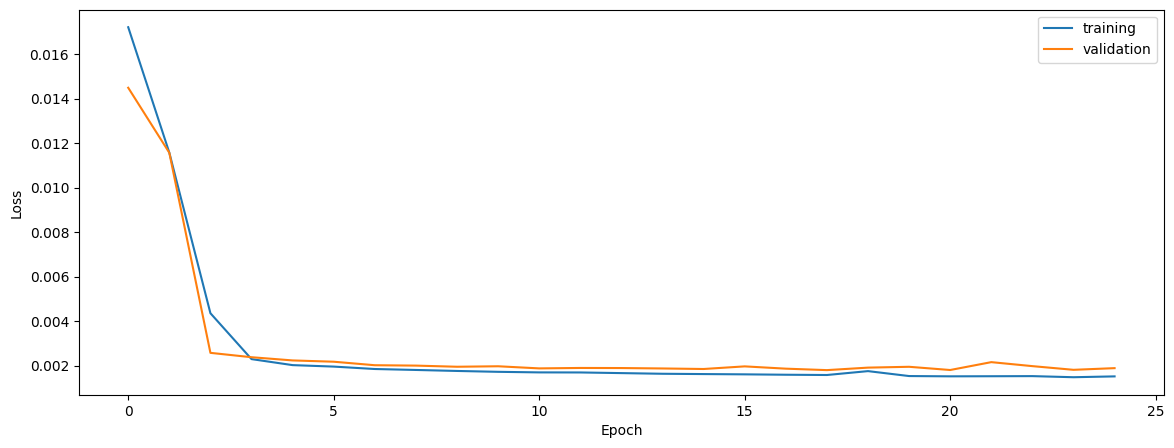

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9348043583247148
0.9359770573260513
0.9410869735386211


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.9348043583247148
0.9359770573260513
0.9410869735386211


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.9370116832635779
0.9371166481312635
0.9505160384786367


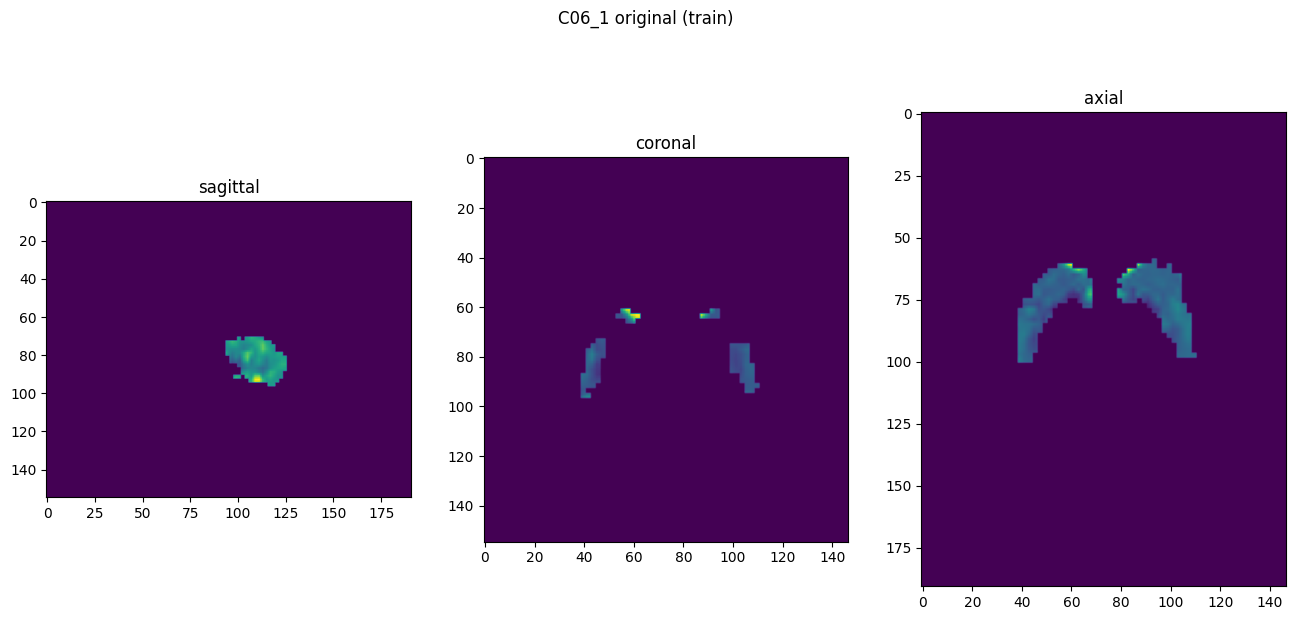

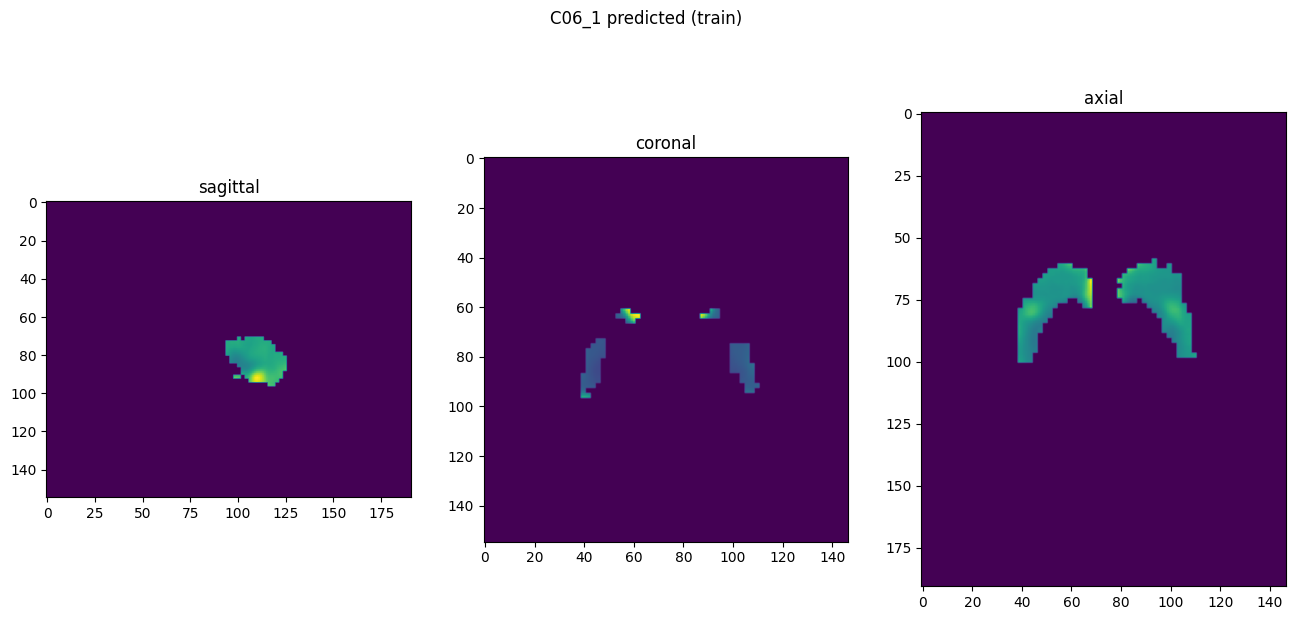

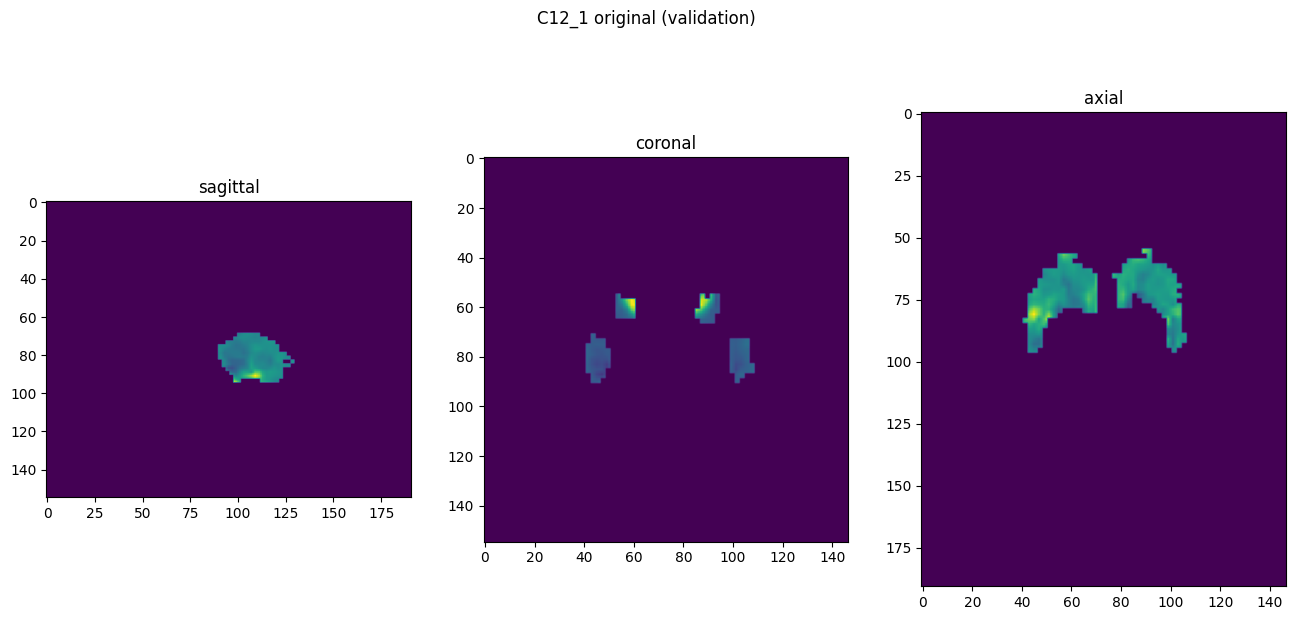

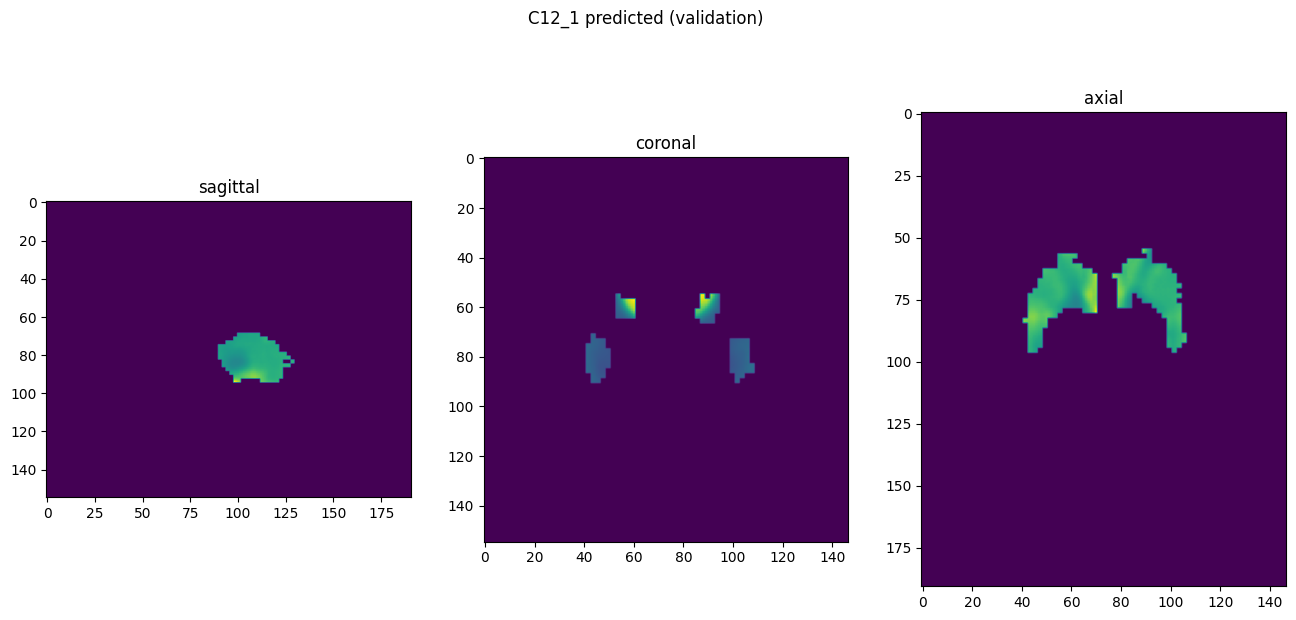

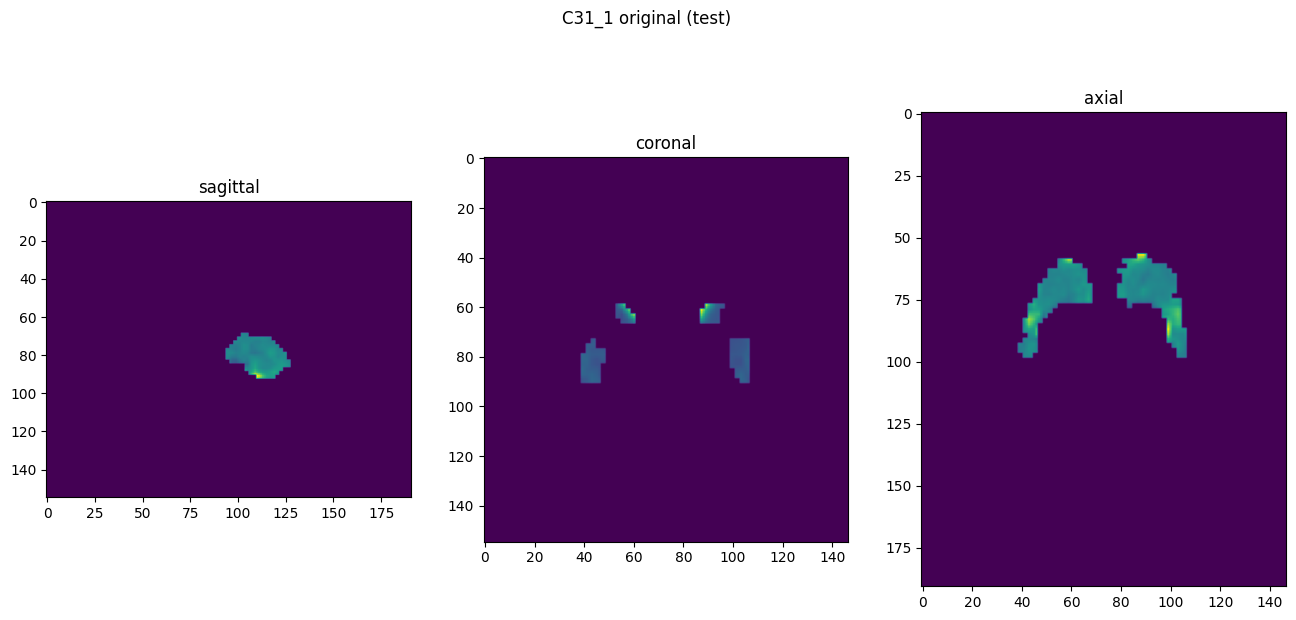

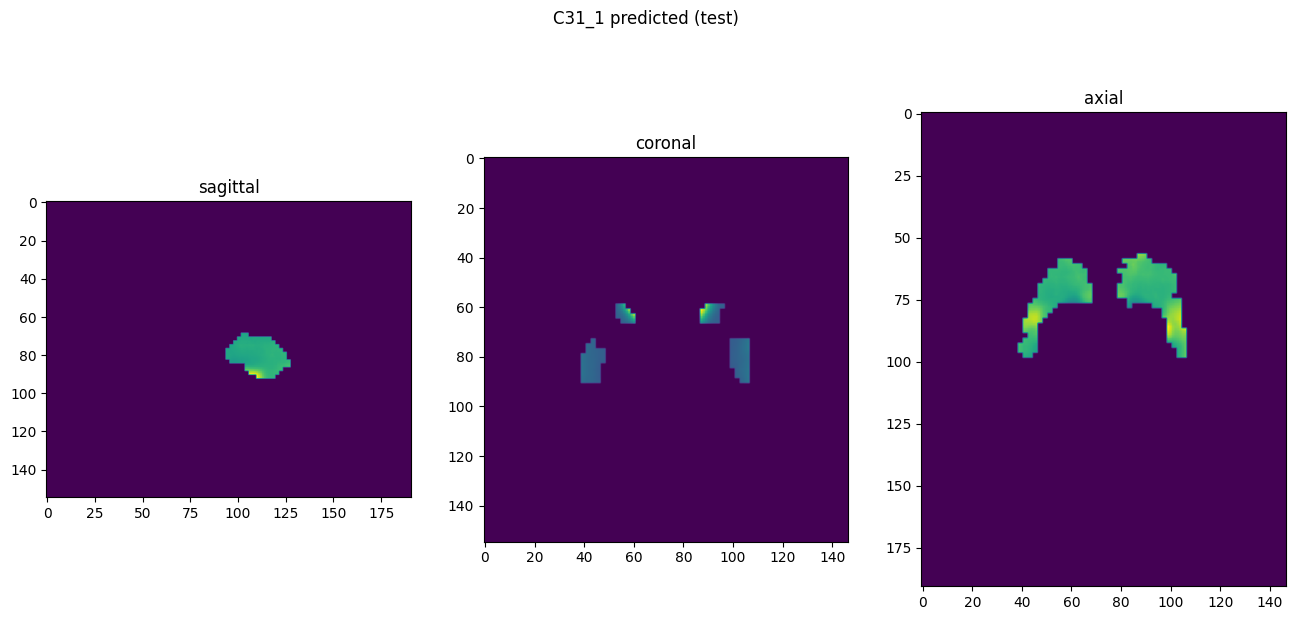

In [10]:
showResults(model, gen, threshold=None, background=False)